### Info
We will use the likely ground truth catalogue (`FDSDWARF_LSB`) and the unfiltered set of objects from which this catalogue is derived (`LSBS_no_par_sel`):
- `LSBS_no_par_sel` contains a number of objects, including many of the objects used in SpaceFluff.
- `FDSDWARF_LSB` contains the objects in the likely ground truth catalogue.

### Goal
The goal of this notebook is to extract the properties (color, surface brightness, effective radius, etc.) of all the objects present in the catalogue, so we can attach them to our SpaceFluff data for analysis. We also want to extract (the names of) the objects thought to be LSB/UDG Fornax cluster members, so we can easily query these objects.

Specifically, we 
- extract the objects, with their name and all the properties we can extract from the .fits files, to `./sf_spacefluff_object_data.csv`
- extract the list of names of objects in the likely ground truth (LGT) catalogue to `sf_catalogue_targets.txt`

### Findings

In this notebook, we'll come to find out that:
- the object names (e.g. 'UDGcand_102') from the catalogue(s) match those used in SpaceFluff, so we can use the objects' names as handles to compare. Alternatively, coordinates (RA/DEC) also be used.
- the two catalogues mentioned above find the same object properties (color, concentration, effective radius, etc.), so it doesn't matter from which of the two we extract the properties. There are a few parameters present in each of the catalogues that aren't in the other, and sometimes the names differ (e.g. `PA` vs `pos_angle`). The only relevant difference for us is the presence of a surface brightness (`mue_r`, $\mu_{e,r}$) in one catalogue. We need this for our analysis.

In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
from sf_lib.df import (
    make_df_classify, 
    make_df_tasks_with_props
)

# Extract catalogue data:

## Extract `FDSDWARF_LSB.fits`:

In [2]:
# load fits file, and extract column names and object data
hdul = fits.open('./FDSDWARF_LSB.fits')
header = hdul[0].header
data_selective = hdul[1].data

col_names = data_selective.columns.names
print('FDSDWARF_LSB columns:', col_names)

# extract each target's name to a list. 
#  these target names match those used in SpaceFluff (we'll verify this later in this notebook)
targets_selective = [d['target'] for d in data_selective if 'UDGcand' in d['target']]

FDSDWARF_LSB columns: ['target', 'RA', 'DEC', 'PA', 'PA_e', 'arat', 'arat_e', 'r_mag', 'r_mag_e', 'g_mag', 'g_mag_e', 'r_nuc', 'g_nuc', 'reff', 'reff_e', 'n', 'n_e', 'u', 'u_e', 'g', 'g_e', 'r', 'r_e', 'i', 'i_e', 'C', 'RFF', 'Class', 'Ref.']


See http://cdsarc.u-strasbg.fr/ftp/J/A+A/620/A165/ReadMe for description of the columns printed above

In [3]:
# Loop over every entry in data_selective (which is the `FDSDWARF_LSB.fits` file) and map its properties to a dictionary.

selected_data = []

for d in data_selective:
    if 'UDGcand' in d['target']:
        
        object_properties = {
            "name": d[0]  # first manually assign 'name', since I prefer 'name' to 'target'
        }
        
        for idx, column in enumerate(data_selective.columns.names[1:]):  # then loop over the rest of the properties 
            object_properties[column] = d[idx+1]                         # and assign the property using its existing name
        
        
        selected_data.append(object_properties)

In [4]:
# save target names to txt file for later comparison to classification votes
#  we only need to this this once. Can uncomment the cell if we need to run it again.

np.savetxt('sf_catalogue_targets.txt', targets_selective, delimiter=',', fmt="%s")

In [5]:
# in notebook `sf_12-04-2021`, I extracted a list of unique target names from `classify-classifications.csv`. 
candidate_names_classify = np.loadtxt('../analysis/sf_candidate_names__classification-classify.txt', dtype=str)

In [6]:
# find intersection of names between FDSDWARF_LSB.fits and classify_classifications.csv
intersecting = list(set(targets_selective) & set(candidate_names_classify))

print('Number of intersecting targets:', len(intersecting))

Number of intersecting targets: 238


## Extract `LSBS_no_par_sel.fits`

In [7]:
hdul = fits.open('./LSBS_no_par_sel.fits')
header = hdul[0].header
data_no_selection = hdul[1].data

# Extract all UDGcand_* targets from LSBS_no_par_sel.
#  Note that this fits file also contains other targets. We might want to check if any of those happen to be 
#   Space Fluff candidates, but with another name. Check using RA/dec (see below)
targets_no_selection = [d['target'] for d in data_no_selection if 'UDGcand' in d['target']]

print('LSBS_no_par_sel columns:', data_no_selection.columns.names)

LSBS_no_par_sel columns: ['target', 'RA', 'DEC', 'Reff', 'r_mag', 'g_mag', 'axis_ratio', 'pos_angle', 'n', 'u', 'g', 'r', 'i', 'ue', 'ge', 're', 'ie', 'Reffe', 'r_mage', 'ne', 'C', 'mue_r', 'bae', 'RFF']


In [8]:
# map targets' properties to a list of objects, same as above with FDS_DWARF_LSB

spacefluff_data = []

for d in data_no_selection:
    object_properties = {
        "name": d[0]
    }
    
    for idx, column in enumerate(data_no_selection.columns.names[1:]):
        object_properties[column] = d[idx+1]
    
    spacefluff_data.append(object_properties)

In [9]:
# convert the list of objects to a DataFrame (and inspect the head to see if it worked properly)
df_spacefluff_data = pd.DataFrame(spacefluff_data)

In [10]:
# save the DataFrame to csv for later use:
df_spacefluff_data.to_csv('./sf_spacefluff_object_data.csv', sep=",", index=False)

# load and inspect created .csv to see if it saved correctly:
df_spacefluff_data_read = pd.read_csv('./sf_spacefluff_object_data.csv', comment="#")

df_spacefluff_data_read.head(2)

,name,RA,DEC,Reff,r_mag,g_mag,axis_ratio,pos_angle,n,u,...,ge,re,ie,Reffe,r_mage,ne,C,mue_r,bae,RFF
0,UDGcand_0,56.232609,-35.335724,2.893400,19.8319,-1.0,0.6034,-27.775499,1.0271,22.426844,...,0.054816,0.046306,0.044244,0.332842,0.131324,0.117142,2.764210,23.585331,0.027318,-99.0
1,UDGcand_1,56.448929,-35.060425,23.859739,16.8575,-1.0,0.5255,-26.768299,0.7523,20.010176,...,0.124959,0.074377,0.064501,5.672080,0.286355,0.215407,3.108573,25.042135,0.049565,-99.0


We see above that there is an `r_mag` and an `r`. I assume these represent magnitudes obtained by various methods. We note that g_mag has a placeholder, so already the assumption here is that `r_mag` is less accurate than `r` also. Below, we plot the parameters against each other, but also the absolute difference between them, and a histogram of each of their errors. We find that `r` is most reliable, and thus we will use this throughout our analysis.

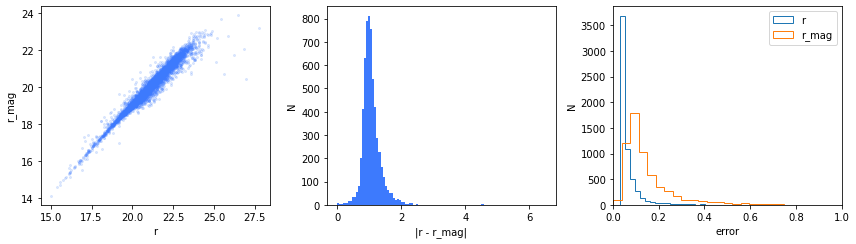

In [11]:
d = df_spacefluff_data_read

lb = 'xkcd:lightish blue'

import matplotlib.pyplot as plt
%matplotlib inline
fig, fr = plt.subplots(1,3, figsize=(12,3.5))

fr[0].scatter(d['r'], d['r_mag'], alpha=0.15, s=4, c=lb)
fr[0].update(dict(xlabel='r', ylabel='r_mag'))

fr[1].hist(np.abs(d['r']-d['r_mag']), bins=101, color=lb)
fr[1].update(dict(xlabel='|r - r_mag|', ylabel='N'))

hist_kw = dict(histtype='step', facecolor='none', bins=51)
fr[2].hist(d['re'], **hist_kw, label='r')
fr[2].hist(d['r_mage'], **hist_kw, label='r_mag')
fr[2].update(dict(xlabel='error', ylabel='N', xlim=[0,1]))
fr[2].legend()

fig.tight_layout()
plt.show()

---
# Compare properties

Compare object properties between the selective and non-selective catalogues, to see if they match or if a different (more resource-intensive) method was used to extract objects' properties in the selective catalogue.

In [12]:
def check_object_property_match(index_sel, index_nosel):
    '''
        Compare all properties (RA, DEC, etc.) between an object in the two .fits files
        @param {int} index_sel: index of the object by this name in selected_data
        @param {int} index_nosel: index of the object by this name in spacefluff_data
        @returns set of booleans. If all properties match, this will equal set([True])
    
    '''
    candidate_sel = selected_data[index_sel]        # properties of candidate according to `FDSDWARF_LSB.fits`
    candidate_nosel = spacefluff_data[index_nosel]  # properties of candidate according to `LSBS_no_par_sel.fits`

    columns_match = []
    
    if candidate_sel['name'] == candidate_nosel['name']:  
        col_sel = set(candidate_sel.keys())      # get properties of objects offered by FDSDWARF_LSB.fits
        col_nosel = set(candidate_nosel.keys())  # ^, but for LSBS_no_par_sel.fits

        col_intersection = col_sel.intersection(col_nosel)  # get the properties present in both the .fits files, 
                                                            #  so we can compare them in a loop
        for column in col_intersection:
            match = candidate_sel[column] == candidate_nosel[column]
            columns_match.append(match)

        set_match = set(columns_match)
        return set_match

In [13]:
objects_sel = [d['target'] for d in data_selective]      # extract target names
objects_nosel = [d['target'] for d in data_no_selection] # ^

objects_intersection = set(objects_sel).intersection(set(objects_nosel))  # get the intersection of target names

In [14]:
# create a lookup table for object indices, 
#  like { 'UDGcand_001': { 'sel': 1, 'nosel': 2 } }, 
#  which would indicate the index of UDGcand_001 to be 1 in the 'sel' file, and 2 in the 'nosel' file
#  start with an empty table, and retrieve indices in a loop the next cell

object_index_lookup = {}
for object_name in objects_intersection:  # create object like {'UDGcand_1': { 'sel': None, 'nosel': None }}
    object_index_lookup[object_name] = {  #  so we only have to loop each *_data list once
        'sel': None,
        'nosel': None
    }

In [15]:
# loop through each list (selected_data and spacefluff_data), and assign the object's index in the list to the lookup

for index, obj in enumerate(selected_data):
    if obj['name'] in objects_intersection:
        object_index_lookup[obj['name']]['sel'] = index
        
for index, obj in enumerate(spacefluff_data):
    if obj['name'] in objects_intersection:
        object_index_lookup[obj['name']]['nosel'] = index

In [16]:
# loop through the lookup and compare each object's properties. if any don't match, the loop'll print the object's name
#  and we can manually inspect what properties differ

all_match = 0
not_in_spacefluff = 0

for (name, indices) in object_index_lookup.items():
    if type(indices['sel']) == int and type(indices['nosel']) == int:
        set_match = check_object_property_match(indices['sel'], indices['nosel'])
        
        if set_match == set([True]):
            all_match += 1
        else:
            print("Properties don't match, investigate!", name, indices) 
    
    else:
        # object doesn't exist in SpaceFluff, which is not a problem
        not_in_spacefluff += 1
        continue
    
len(objects_intersection) == all_match + not_in_spacefluff

True

As we see, none of the objects have non-matching properties, meaning we're free to use the properties from either .fits file.

## Check if any of the non-`UDGcand` objects have coordinates corresponding to objects in SpaceFluff, somehow

Note from above that not all objects in the catalogue(s) are named `UDGcand_*`. Are the properties still the same for the objects with other names? This is not relevant for our project since we only use `UDGcand_*` objects, but good as a sanity check regardless.

- load spacefluff objects and their properties

In [17]:
object_info = pd.read_csv('./sf_spacefluff_object_data.csv', comment="#")
candidate_names_classify = list(np.loadtxt('../analysis/sf_candidate_names__classification-classify.txt', dtype='str'))

In [18]:
df = make_df_classify(workflow='classify')
df_votes = make_df_tasks_with_props(df, candidate_names_classify, object_info)

- list all RA and DEC values of catalogue objects that aren't named `UDGcand_*`

In [19]:
ra_index = data_selective.columns.names.index('RA')
dec_index = data_selective.columns.names.index('DEC')

ras = [d[ra_index] for d in data_selective if d['target'].find('UDGcand') == -1]
decs = [d[dec_index] for d in data_selective if d['target'].find('UDGcand') == -1]

- see if any of these RA or DEC values correspond to SpaceFluff objects

In [20]:
dec_exists = df_votes.query("RA.isin(@ras) or DEC.isin(@decs)")
_names = dec_exists['name'].tolist()

In [21]:
decs_in_df = dec_exists['RA'].tolist()
ras_in_df = []

for dec in decs_in_df:
    try:
        ras_in_df.append(ras.index(dec))
    except:
        ras_in_df.append(-1)
    
ras_in_df

[-1, -1, -1, -1, -1]

- All indices are -1, so none of the (RA, DEC) combinations exist, and thus none of the non-`UDGcand_*` objects are in fact SpaceFluff objects.

In [24]:
names_selective = [d[0] for d in data_selective]

In [28]:
names_all = np.array([d[0] for d in data_no_selection])

In [38]:
len([n for n in names_all if 'UDGcand' in n ])

6036